In [1]:
import json
from pathlib import Path

import albumentations as A
import cv2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from PIL import Image

In [2]:
# width or x - горизонталь
# height or y - вертикаль
# Each row is - class x_center y_center width height format.
# Box coordinates must be in normalized xywh format (from 0 - 1). If your boxes are in pixels, divide x_center and width by image width, and y_center and height by image height.
# Class numbers are zero-indexed (start from 0).
# пример строки в файле .txt - '45 0.479492 0.688771 0.955609 0.5955\n'

In [9]:
dir_1 = 'datasets/coco128/labels/train2017'
dir_2 = '../train_dataset_train/labels/'

labels_dir = Path(dir_2)

def get_files(files_dir: Path, suff: str = 'txt') -> list[Path]:
    return sorted(Path(files_dir).glob(f'*.{suff}'))

labels = get_files(labels_dir)

with open(labels[4], 'r') as label:
    data = label.readlines()

data

IndexError: list index out of range

# Преобразование координат объектов в формат yolo

## Загрузка координат в pandas

In [3]:
location_csv = Path('../train_dataset_train/train.csv')
location_image = Path('../train_dataset_train/train')
location_labels = Path('../train_dataset_train/labels')

In [4]:
location = pd.read_csv(location_csv)

In [5]:
location

,ID_img,count_region,region_shape
0,3376.JPG,0.0,0.0
1,3377.JPG,0.0,0.0
2,3378.JPG,0.0,0.0
3,3379.JPG,0.0,0.0
4,3380.JPG,0.0,0.0
...,...,...,...
5059,8435.JPG,0.0,0.0
5060,8436.JPG,0.0,0.0
5061,8437.JPG,0.0,0.0
5062,8438.JPG,0.0,0.0


In [ ]:
location[location['region_shape'] != '0.0']

In [8]:
def get_size(image_file: Path) -> tuple[int, int]:
    forest_image = Image.open(image_file)
    width, height = forest_image.size
    return width, height

In [9]:
def get_fraction(image_size: tuple[int, int], location: list[dict[str, int]]) -> list[list[float]]:
    # location consist: 
    # ‘r’ - область внутри которой находиться человек
    # ‘cx’ - центр окружности по координате x
    # ‘cy’ - центр окружности по координате y
    boxes = []
    width, height = image_size
    for box in location:        
        center_x = str(box['cx'] / width)
        center_y = str(box['cy'] / height)
        box_width = str(box['r'] / width)
        box_height = str(box['r'] / height)
        boxes.append(['0', center_x, center_y, box_width, box_height])
    return boxes


In [10]:
def get_text(boxes: list[list[float]]) -> list[str]:
    boxes_str = []
    for location in boxes:
        new_line = ' '.join(location) + '\n'
        boxes_str.append(new_line)
    return boxes_str

In [11]:
def write_txt(boxes: list[str], name: str) -> None:
    txt_file = location_labels / f'{name}.txt'
    with open(txt_file, 'w') as new_file:
        for row in boxes:
            new_file.write(row)

In [14]:
def row_handler(row: pd.Series) -> None:
    #print(type(row))
    name, coord = row['ID_img'], row['region_shape']
    short_name = name.split('.')[0]
    boxes = json.loads(coord.replace("\'", ""))
    image_file = location_image / name
    size = get_size(image_file)
    boxes = get_fraction(size, boxes)
    boxes = get_text(boxes)
    write_txt(boxes, short_name)
    #print(boxes)

image_file = Path('../train_dataset_train/train/3771.JPG')
size = get_size(image_file)
size

coord = location.iloc[395]['region_shape']
boxes = json.loads(coord.replace("\'", ""))
boxes = get_fraction(size, boxes)
boxes = get_text(boxes)
boxes

In [ ]:
# исключаем строки где нет людей и преобразуем координаты в текстовый файл
location[location['region_shape'] != '0.0'].apply(row_handler, axis=1)

# Аугументация датасета

In [273]:
aug_dir = Path('../train_dataset_train/augumentation')
aug_size = 256

In [274]:
labels_list = get_files(location_labels)

In [275]:
transform_person = A.Compose(
    [A.RandomSizedBBoxSafeCrop(width=aug_size, height=aug_size, erosion_rate=0.9)],
    bbox_params=A.BboxParams(format='yolo', label_fields=['class_labels']),
)

In [276]:
transform_area = A.Compose([
    A.RandomCrop(width=aug_size, height=aug_size),
    A.HorizontalFlip(p=0.5),
    A.RandomBrightnessContrast(p=0.2),
], bbox_params=A.BboxParams(format='yolo', min_visibility=0.2, label_fields=['class_labels']))

In [291]:
def transformer_person(image, bboxes, class_labels):
    transformed = transform_person(image=image, bboxes=bboxes, class_labels=class_labels)
    transformed_image = transformed['image']
    transformed_bboxes = transformed['bboxes']
    transformed_class_labels = transformed['class_labels']    
    return transformed_image, transformed_bboxes

In [288]:
def transformer_area(image, bboxes, class_labels):
    transformed = transform_area(image=image, bboxes=bboxes, class_labels=class_labels)
    transformed_image = transformed['image']
    transformed_bboxes = transformed['bboxes']
    transformed_class_labels = transformed['class_labels']    
    return transformed_image, transformed_bboxes

In [280]:
def read_boxes(label_path: Path) -> list[str]:
    with open(label_path, 'r') as label:
        label_list = label.readlines()
    return label_list

In [281]:
def get_image(image_path: Path):
    #image = Image.open(image_path)
    image = cv2.imread(str(image_path))
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    return image

In [282]:
def get_boxes(label_path: Path) -> tuple[list[float], list[str]]:
    boxes = read_boxes(label_path)
    boxes_list = []
    labels = []
    for box in boxes:
        box = box.replace('\n', '')
        box = box.split(' ')
        bbox = [float(x[:11]) for x in box[1:]]
        boxes_list.append(bbox)
        labels.append(box[0])
    return boxes_list, labels

In [283]:
def save_image() -> None:
    pass

In [284]:
def save_label(boxes: list) -> None:
    pass

In [285]:
def show_image(image, mask):
    if len(mask) > 0:
        fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(25,25))
        axes[0].imshow(image)
        #axes[1].imshow(mask[..., 0])
        plt.show

In [300]:
BOX_COLOR = (255, 0, 0) # Red
TEXT_COLOR = (255, 255, 255) # White

def visualize_bbox(img, bbox, class_name, color=(250,0,0), thickness=1):
    """Visualizes a single bounding box on the image"""
    print(img.shape)
    x_c, y_min, w, h = bbox
    x_min, x_max, y_min, y_max = int(x_c*256-(w*256)), int(x_c*256 + (w*256)), int(y_min*256-(h*256)), int(y_min*256 + (h*256))
   
    cv2.rectangle(img, (x_min, y_min), (x_max, y_max), color=color, thickness=thickness)
    
    ((text_width, text_height), _) = cv2.getTextSize(class_name, cv2.FONT_HERSHEY_SIMPLEX, 0.25, 1)    
    cv2.rectangle(img, (x_min, y_min - int(1.3 * text_height)), (x_min + text_width, y_min), BOX_COLOR, -1)
    cv2.putText(
        img,
        text=class_name,
        org=(x_min, y_min - int(0.3 * text_height)),
        fontFace=cv2.FONT_HERSHEY_SIMPLEX,
        fontScale=0.35, 
        color=TEXT_COLOR, 
        lineType=cv2.LINE_AA,
    )
    return img

def visualize(image, bboxes, category_ids=['0'], category_id_to_name={'0': 'person'}):
    img = image.copy()
    
    for bbox, category_id in zip(bboxes, category_ids):
        class_name = category_id_to_name[category_id]
        img = visualize_bbox(img, bbox, class_name)
    plt.figure(figsize=(12, 12))
    plt.axis('off')
    plt.imshow(img)

In [311]:
def start_aug():
    for label_file in labels_list:
        image_path = location_image / f'{label_file.stem}.JPG'
        image = get_image(image_path)
        bboxes, class_labels = get_boxes(label_file)
        for _ in range(5):
            new_image, new_bboxes = transformer_person(image, bboxes, class_labels)
            print(bboxes, new_bboxes)
            category_ids = ['0']* len(new_bboxes)
            visualize(new_image, new_bboxes, category_ids)
            #show_image(new_image, new_bboxes)
            #cv2.waitKey(0)
            new_image, new_bboxes = transformer_area(image, bboxes, class_labels)
            category_ids = ['0'] * len(new_bboxes)
            visualize(new_image, new_bboxes, category_ids)
            
        break

[[0.49616228, 0.136127355, 0.024305555, 0.043209876]] [(0.7453548571915931, 0.5947136544640235, 0.0405117261529091, 0.195301025444934)]
(256, 256, 3)
[[0.49616228, 0.136127355, 0.024305555, 0.043209876]] [(0.15696061905712708, 0.04142632338227583, 0.07376594396006673, 0.06974305103723126)]
(256, 256, 3)
[[0.49616228, 0.136127355, 0.024305555, 0.043209876]] [(0.2188200120687081, 0.14231136518147086, 0.09932785433905925, 0.06351480340401147)]
(256, 256, 3)
[[0.49616228, 0.136127355, 0.024305555, 0.043209876]] [(0.4958910026297578, 0.13663366284752476, 0.02876297512110737, 0.05267326666455446)]
(256, 256, 3)
[[0.49616228, 0.136127355, 0.024305555, 0.043209876]] [(0.1400679084550086, 0.009567761786132375, 0.11290322322580672, 0.01913552357226475)]
(256, 256, 3)


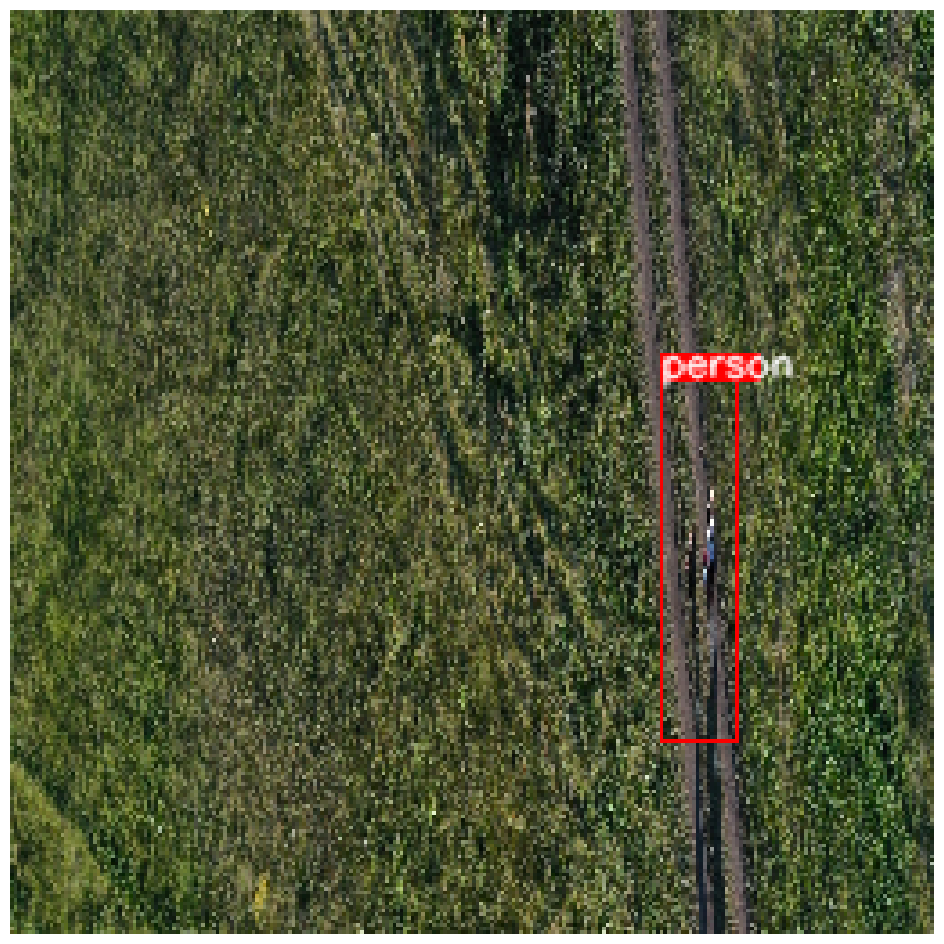

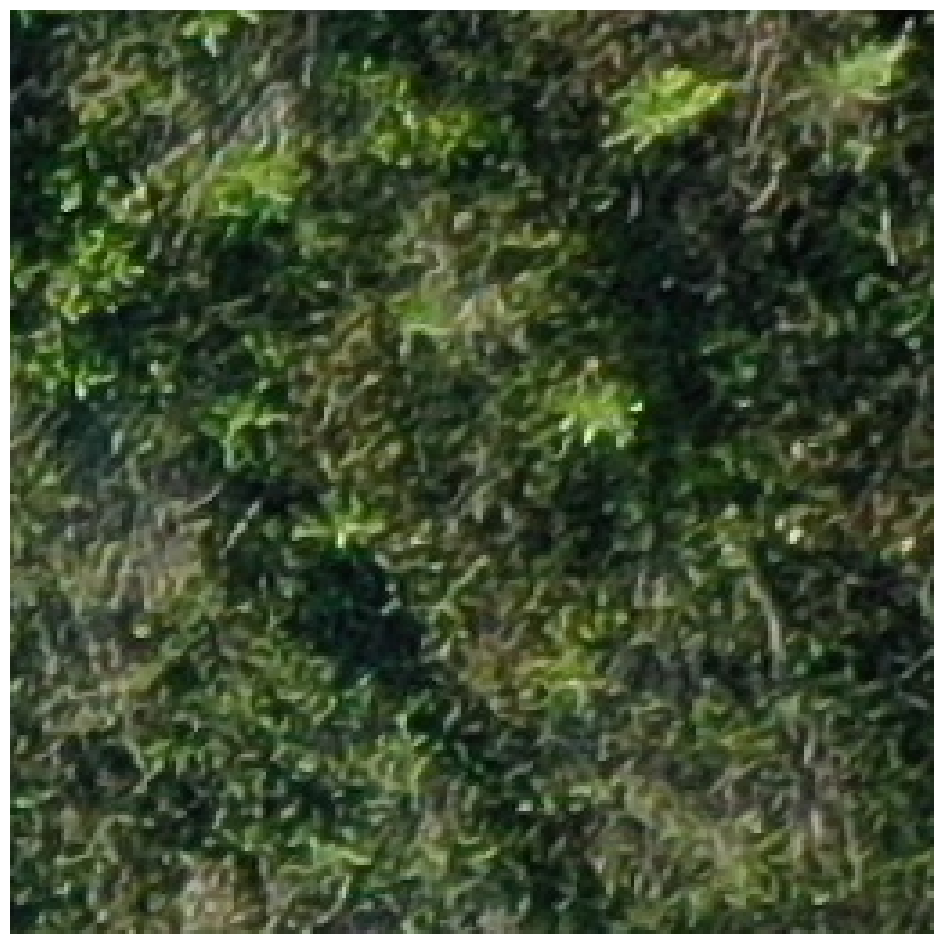

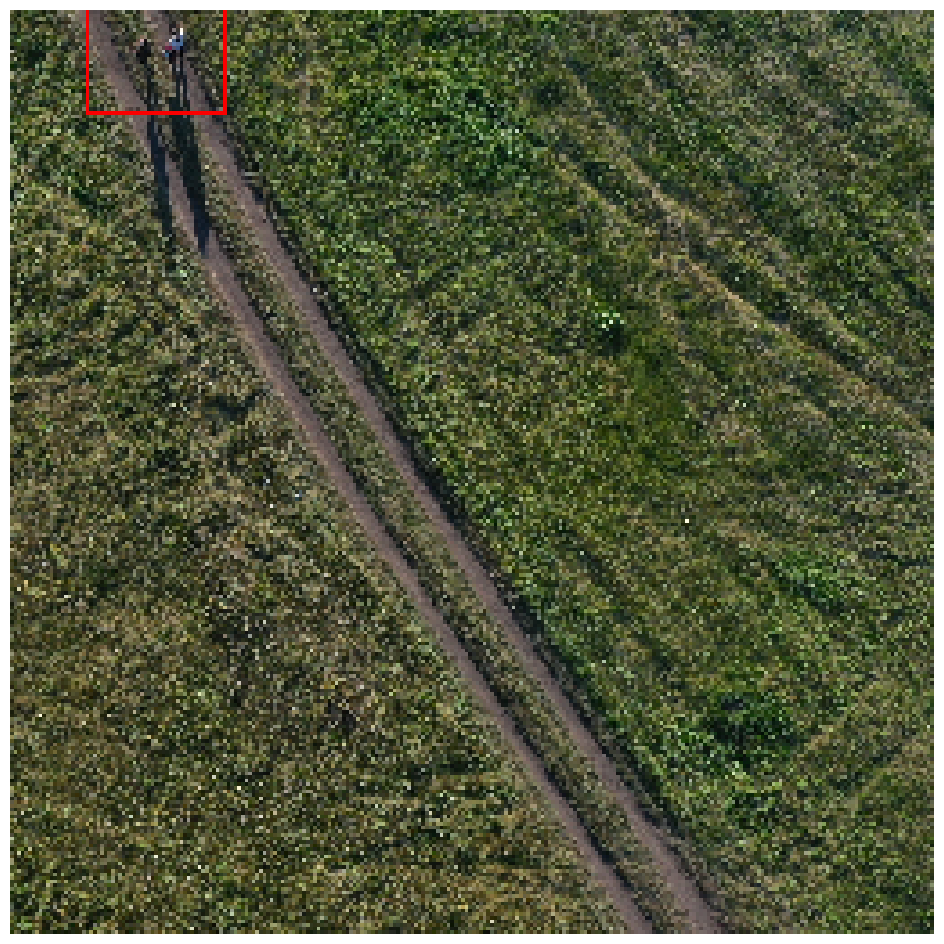

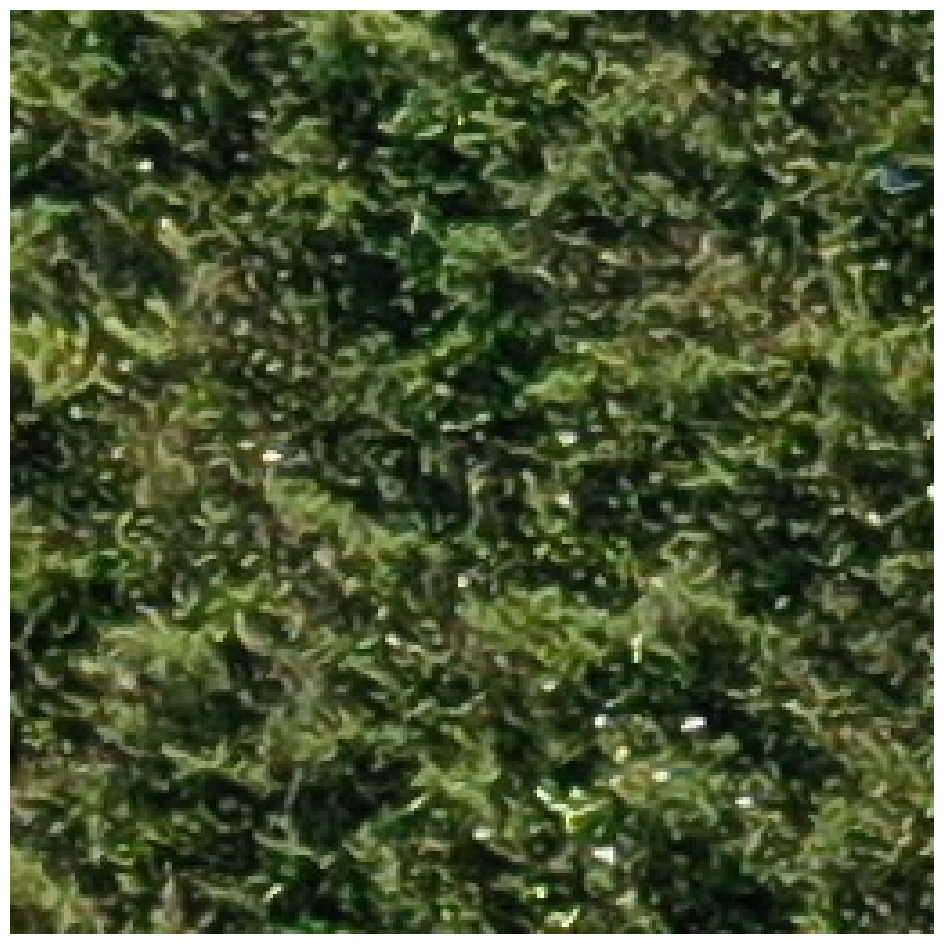

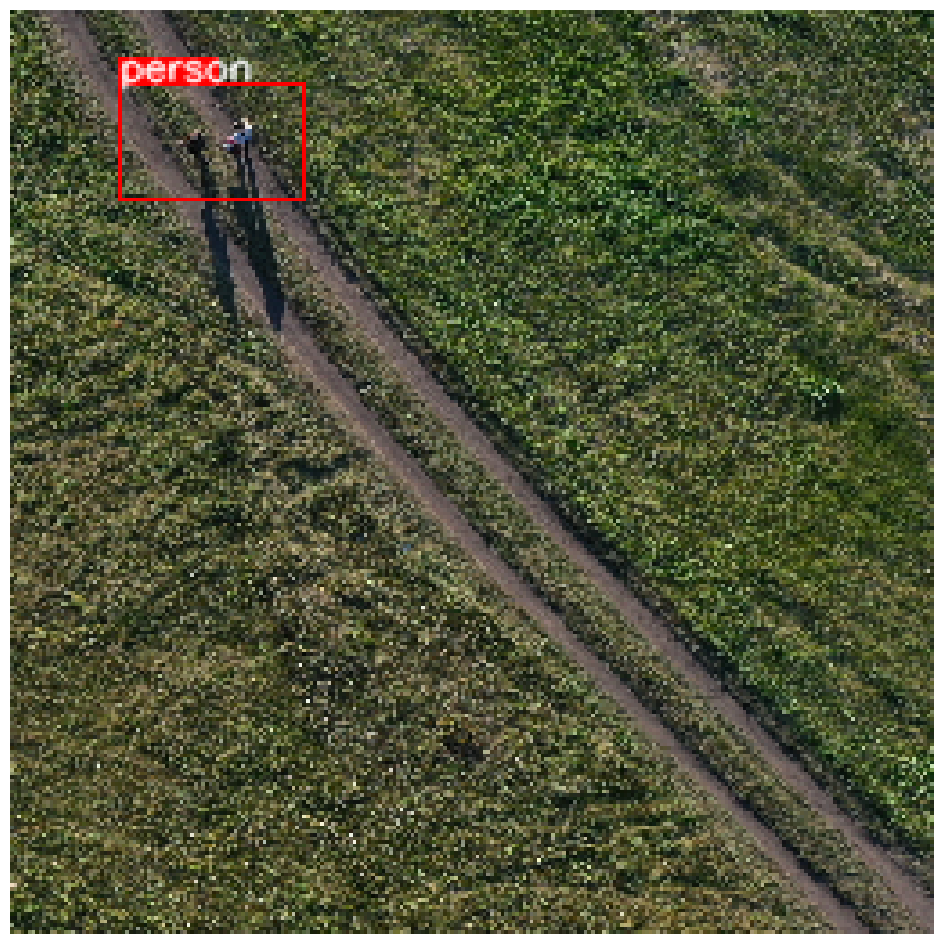

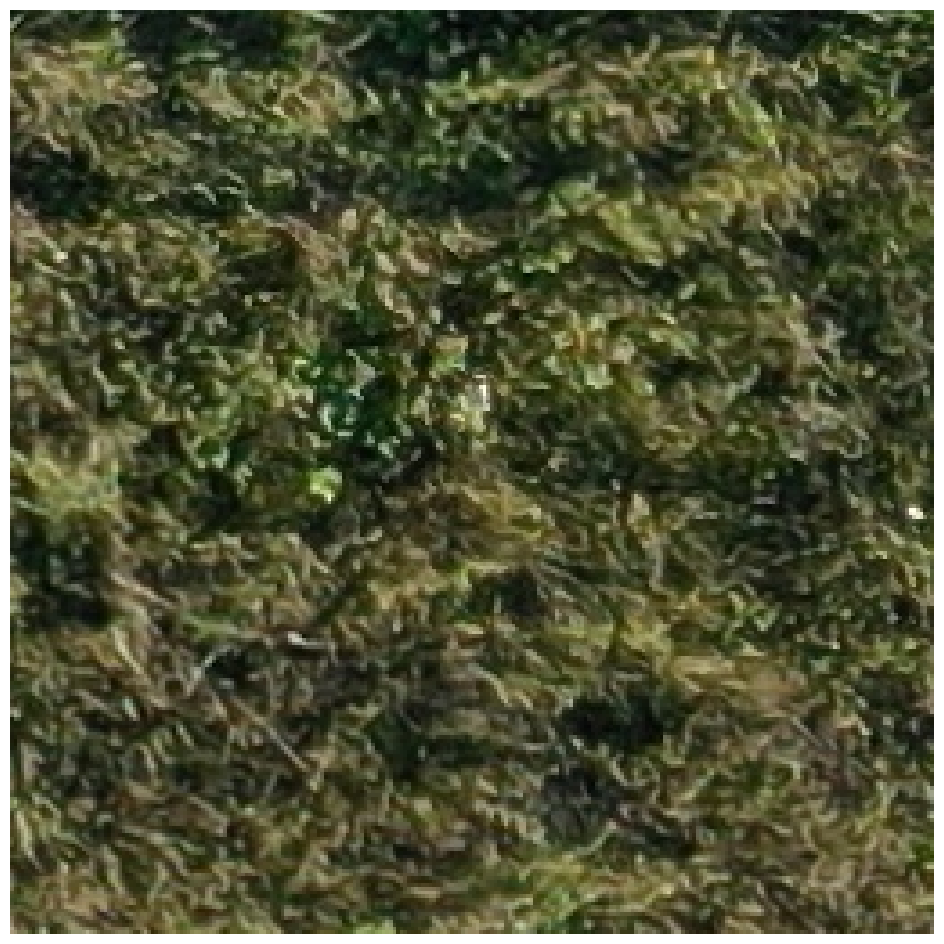

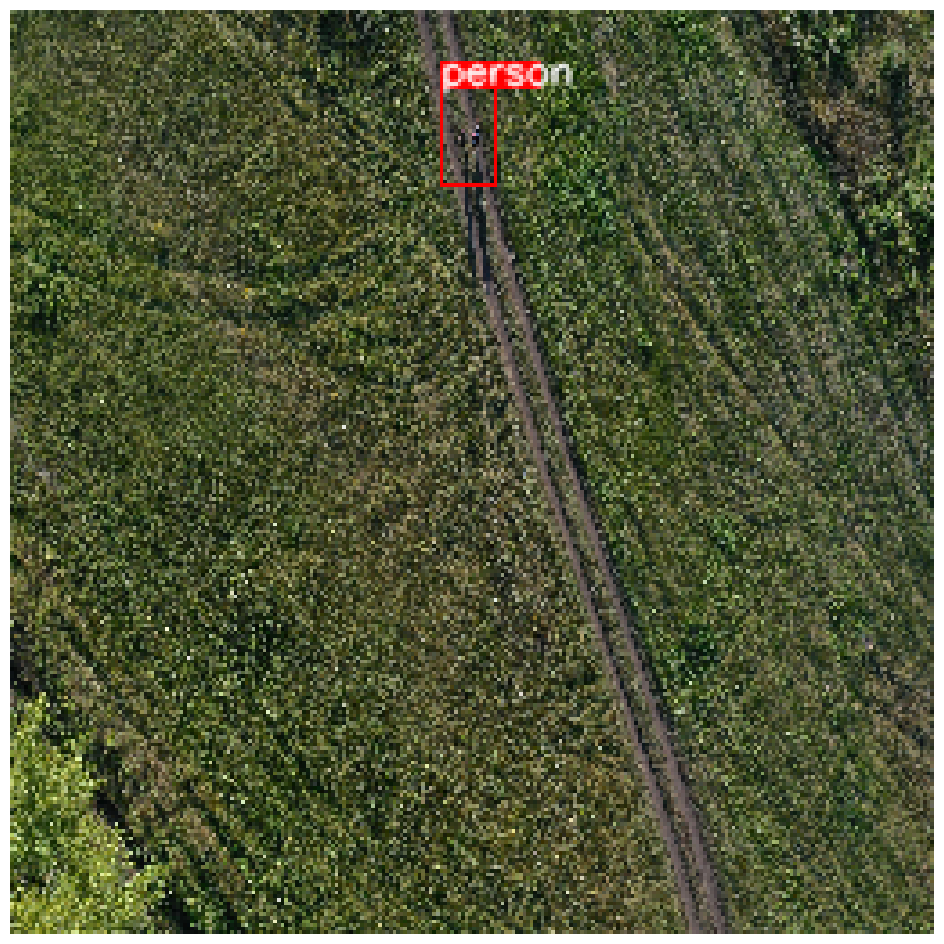

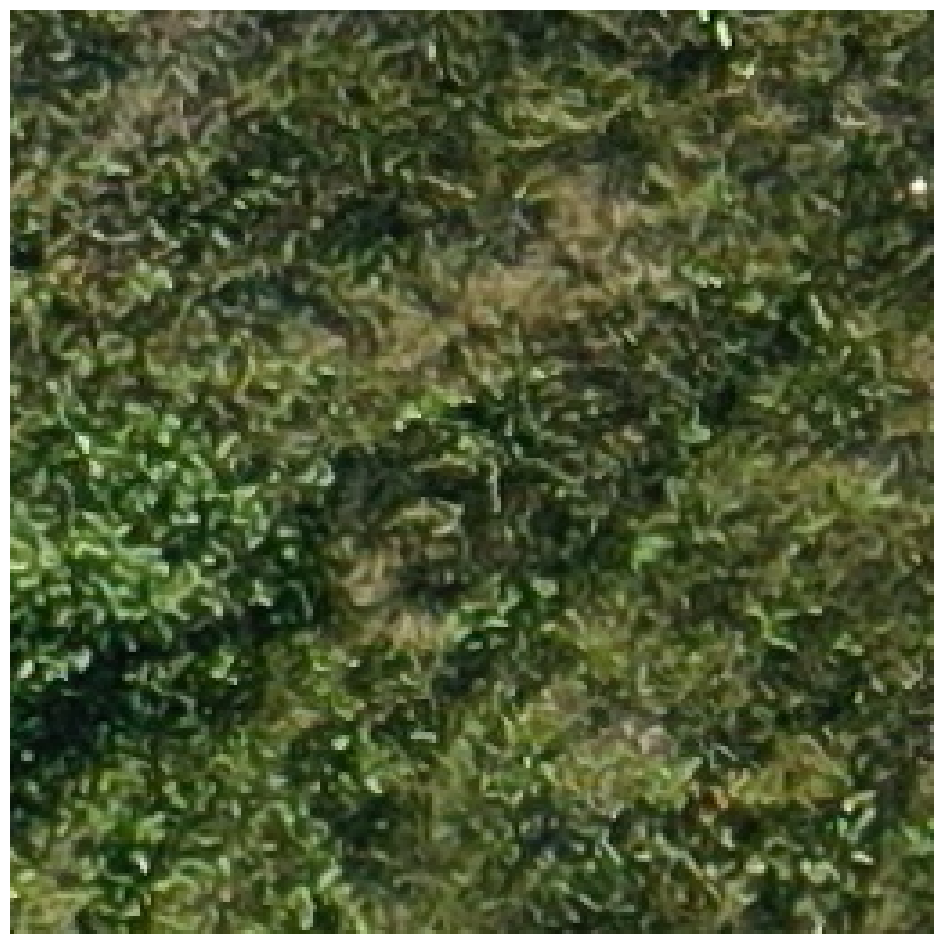

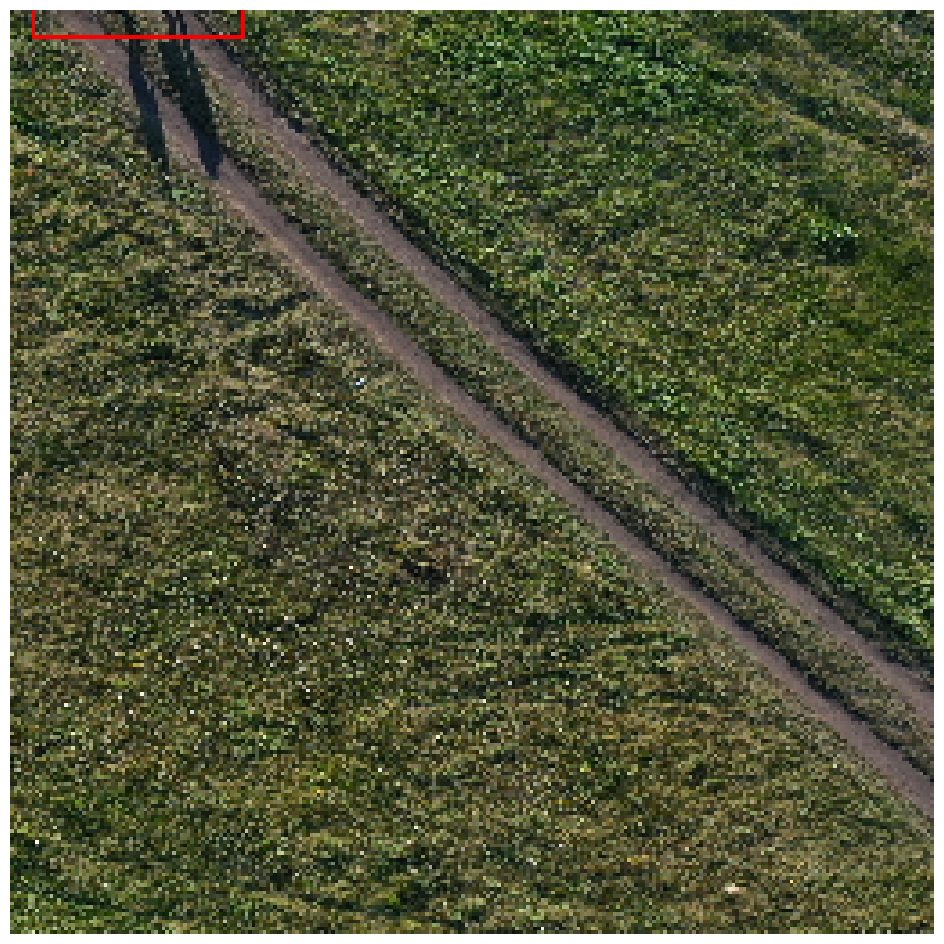

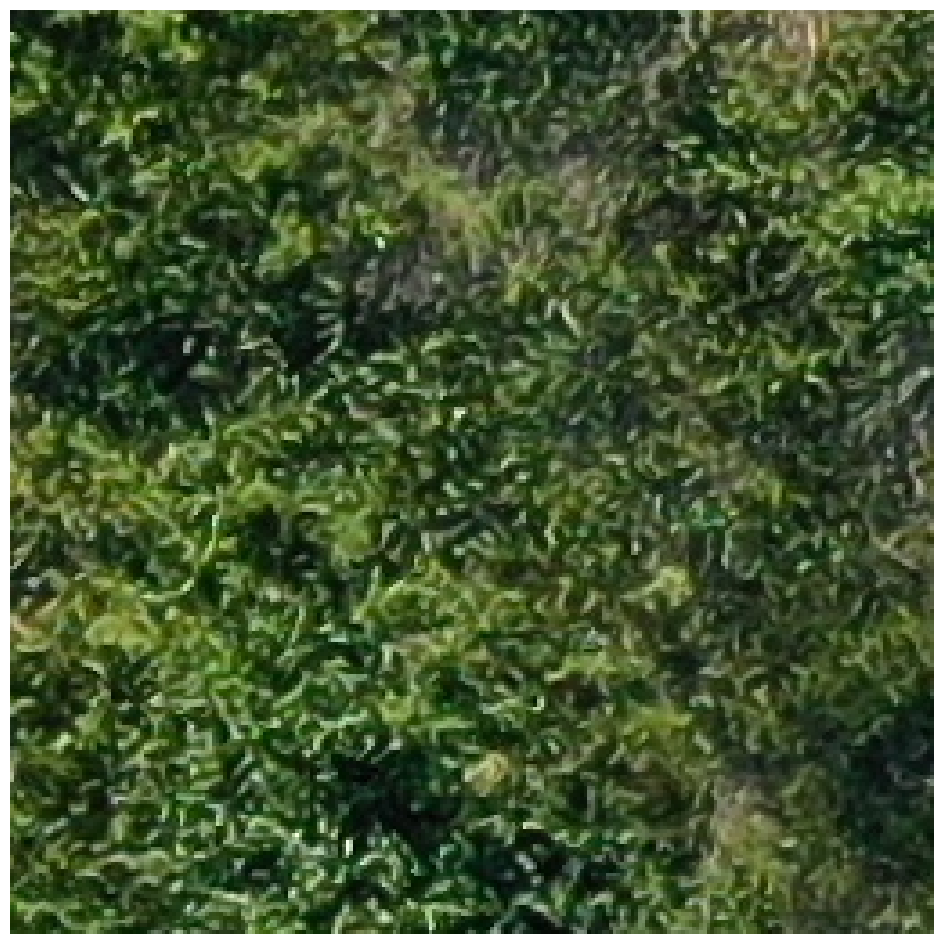

In [312]:
start_aug()

In [308]:
['0']*5

['0', '0', '0', '0', '0']